In [1]:
# All imports go here. Run me first!
import datetime
from pathlib import Path  # Checks for files and so on
import numpy as np  # Numpy for arrays and so on
import pandas as pd
import sys
import matplotlib.pyplot as plt  # Matplotlib for plotting
# Ensure the plots are shown in the notebook
%matplotlib inline

import gdal
import osr
import numpy as np
%matplotlib inline

# Fitting non-linear models

In the previous session, we looked at fitting linear models to observations. While this is a very common task, complex processes might require models which are non-linear.

<div class="alert alert-success">
Can you think of any non-linear models that you have come across?
</div>

One non-linear model is modelling LAI as a function of time (or temperature). In the Nothern Hemisphere, and for temperate latitudes, there is a clear seasonal cycle in vegetation, particularly visible in leaf area index (LAI). LAI dynamics can possibly be depicted by a "double logistic" curve. Mathematically, the double logistic looks like this


![A double logistic](https://camo.githubusercontent.com/7a664a29ec5bc190d71d8ba5ec391bcf98848df7/687474703a2f2f777777322e67656f672e75636c2e61632e756b2f7e706c657769732f67656f67673132342f5f696d616765732f7a68616e67312e706e67)

Mathematically, the function predicts the e.g. LAI (or some vegetation index) as

$$
y = p_0 - p_1\cdot\left[\frac{1}{1+\exp\left(p_2\cdot(t-p_3)\right)} + \frac{1}{1+\exp\left(-p_4\cdot(t-p_5)\right)} - 1\right].
$$

If we inspect this form, we can probably guess that $p_0$ and $p_1$ scale the vertical span of the function, whereas $p_3$ and $p_5$ are some sort of temporal shift, and the remaining parameters $p_2$ and $p_4$ control the slope of the two flanks. Something that will give rise to a self-respecting LAI curve might be

* $p_0= 0.1$
* $p_1= 2.5$
* $p_2=0.19$
* $p_3= 120$
* $p_4= 0.13$
* $p_5= 220$

<div class="alert alert-danger">
<p>Write a function that produces the double logistic when passed an array of time steps (e.g. 1 to 365), and an array with six parameters.</p>
<p>Do some plots and try to get some intuition on the model parameters!</p>
</div>



## A synthetic experiment

A first step is to do a synthetic experiment. This has the marked advantage of being a situation where we're in control of everything. 

Text(0,0.5,'LAI')

/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


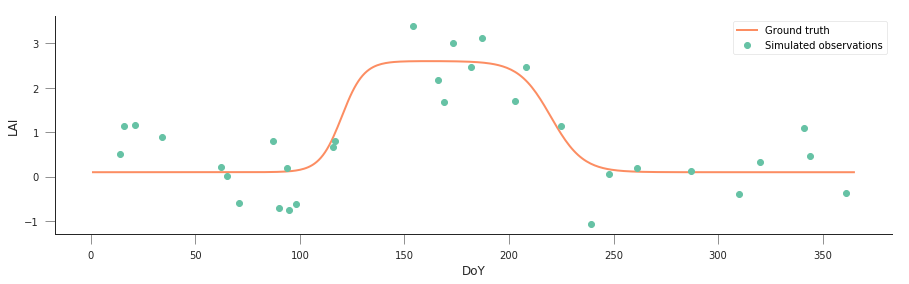

In [2]:

t = np.arange(1, 366)
p = np.array([0.1, 2.5, 0.19, 120, 0.13, 220])
y = dbl_sigmoid_function(p, t)
yn = y + np.random.randn(len(t))*0.6

selector = np.random.rand(365)

passer = np.where(selector > 0.9, True, False)

tn = t[passer]
yn = yn[passer]

fig = plt.figure(figsize=(15, 4))
_ = plt.plot(t, y, '-', label="Ground truth")
_ = plt.plot(tn, yn, 'o', label="Simulated observations")
plt.legend(loc="best")
plt.xlabel("DoY")
plt.ylabel("LAI")



We know that the "true parameters" are given by `p = np.array([0.1, 2.5, 0.19, 120, 0.13, 220])`, but we see that the data is quite noisy and has significant gaps. As per last session, we could try to modify the parameters "by hand", and see how far we get, but given that it's 6, with different ranges, it looks a bit daunting. Also, we'd need to assess how good the solution is for a particular set of parameters, in other words, select a metric to quantify the goodness of fit.

It is useful to consider a model of the incomplete, noisy observations of LAI ($y_n$) and the true value of LAI, $y$. For overlapping time steps, the noisy data are just the "true" data plus some random Gaussian value with zero mean and a given variance $\sigma_{obs}^2$ (in the experiment above, $\sigma_{obs}=0.6$):

$$
y_n^{i} = y^{i} + \mathcal{N}(0, \sigma_{obs}^2).
$$

Rearranging things, we have that $y_n - y$ should be a zero mean Gaussian distribution with known variance. We have assumed that our model is $f(\vec{p})=y$, so we can write the *likelihood function*, $l(\vec{p})$

$$
l(\vec{p}) = \left[\frac{1}{\sqrt{2\pi\sigma_{obs}^2}}\right]^{N}\displaystyle{\prod_{i=1}^{N} \exp\left[-\frac{(y_n^{i}-f(\vec{p})^{i})^2}{2\sigma_{obs}^2}   \right]}.
$$

It is convenient to take a logarithm of $l(\vec{p})$, so that we have the **log-likelihood**:

$$
L(\vec{p}) = -\displaystyle{\sum_{i=1}^{N} \left[\frac{(y_n^{i}-f(\vec{p})^{i})^2}{2\sigma_{obs}^2}   \right]} + \textrm{Const.}
$$

<div class="alert alert-success">
Think about the likelihood and log-likelihood... Think (and possibly plot) how a negative exponential curve looks like, and what conditions are for some interesting points.
</div>

/home/ucfajlg/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


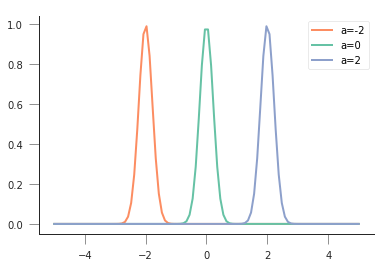

So for a sum of squares, the most likely result would be if all the mismatches were zero, which means that the log-likelihood is 0, and the likelihood, $exp(0)=1$! 

However, the mismatch might not be 0, due to the added noise. So what we're effectively looking for is a **maximum** in the log-likelihood, or a **minimum** of its negative as a function of $\vec{p}$:

$$
\frac{\partial (-L(\vec{p}))}{\partial \vec{p}} \triangleq \min
$$

So, we can try our brute force guessing approach by **minimising the cost function given by $L(\vec{p})$**

<div class="alert alert-danger">
Write the cost function! Test it possibly shifting one parameter over some range of values
</div>

The easiest way to obtain the solution is to use numerical optimisation techniques to minimise the cost function. In scipy, there's [a good selection of function optimisers](https://docs.scipy.org/doc/scipy/reference/optimize.html). We'll be looking at **local** optimisers: these will look for a minimum in the vicinity of a user-given starting point, usually by looking at the gradient of the cost function. The main function to consider here is [`minimise`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize). Basically, `minimize` takes a cost function, a starting point, and maybe extra arguments that are passed to the cost function, and uses one of several algorithms to minimise the cost function. We import it with

```python
    from scipy.optimize import minimize
```

From the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize),
```python
    minimize(fun, x0, args=(), method=None,
             jac=None, hess=None, hessp=None,
             bounds=None, constraints=(), tol=None,
             callback=None, options=None)
```

Basically, `fun` is the name of the cost function. The first parameter you pass to the cost function has to be an array with the parameters that will be used to calculate the cost. `x0` is the starting point. `args` allows you to add extra parameters that are required for the cost function (in our example, these would be `t, y_obs, passer, sigma_obs`).

The `minimize` function returns an object with the 

1. Value of the function at the minimum,
2. The value of the input parameters that attain the minimum,
3. A message telling you whether the optimisation succeeded
4. The number of iterations (`nit`) and total function evaluations (`nfev`)
5. Some diagnostics 





In [ ]:
from scipy.optimize import minimize

In [44]:
from scipy.optimize import minimize

p0 = np.array([0, 5, 0.01, 90, 0.01, 200])

retval = minimize(cost_function, p0, args=(t, yn, passer, 0.6))

print(retval)

print ("********************************************")
if retval.success:
    print("Optimisation successful!")
    print(f"Value of the function at the minimum: {retval.fun:g}")
    print(f"Value of the solution: {str(retval.x):s}")

      fun: 21.342085853280015
 hess_inv: array([[ 1.72923106e-02, -2.15349312e-02,  2.11636346e-03,
         2.98572159e-02,  4.47526187e-03, -5.30376564e-02],
       [-2.15349312e-02,  1.13986002e-01, -4.73509772e-02,
         5.02075575e-01, -5.17466259e-02, -4.55944527e-01],
       [ 2.11636346e-03, -4.73509772e-02,  7.51102753e-02,
        -5.51690150e-01,  2.61989471e-02,  2.73170740e-01],
       [ 2.98572159e-02,  5.02075575e-01, -5.51690150e-01,
         9.54855368e+00, -3.19209970e-01, -3.30673084e+00],
       [ 4.47526187e-03, -5.17466259e-02,  2.61989471e-02,
        -3.19209970e-01,  5.74465509e-02,  3.44439220e-01],
       [-5.30376564e-02, -4.55944527e-01,  2.73170740e-01,
        -3.30673084e+00,  3.44439220e-01,  8.29858275e+00]])
      jac: array([ 4.76837158e-07,  4.52995300e-06, -4.76837158e-07, -4.76837158e-07,
        9.53674316e-07,  4.76837158e-07])
  message: 'Optimization terminated successfully.'
     nfev: 616
      nit: 63
     njev: 77
   status: 0
  success

<div class="alert alert-danger">
Do some synthetic experiments. For example:
<ol>
    <li> Change the true parameters and see how the solution tracks the change.</li>
    <li> Increase the added variance</li>
    <li> Reduce or increase the number of observations</li>
</ol>

Use these experiments to challenge your understanding of the problem: Try to think what the expected result of these changes is, and write a set of functions that simplify the exploration.
</div>





## Next: Real data

In the next session, you'll be applying these techniques to MODIS LAI data